## ANOVA计算F值曲线、可视化图代码
##### https://www.kaggle.com/code/hamelg/python-for-data-26-anova/notebook

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import os
import seaborn as sns
# np.set_printoptions(threshold=np.inf) # 使print大量数据不用符号...代替而显示所有
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# 读取csv文件并返回为numpy格式
def read_csv(path):
    txt = pd.read_csv(path, header=None, dtype=np.float64)
    # 必须添加header=None，否则默认把第一行数据处理成列名导致缺失
    list = txt.values.tolist()
    return np.array(list)

# 计算波段的比值函数, spec为输入光谱, axis表示sample按行、列排布
def get_ratio(spec, band, axis=0, sort=True):
#     print("Data shape: " + str(spec.shape))
    ratio = np.array([], dtype=np.float)
    if axis==0 and spec.shape[1] < 225:  # 按行取光谱样本
        for sample in spec:
            ratio = np.append(ratio, (sample[band[0]]+1) / (sample[band[1]]+1) )
    elif axis==1 and spec.T.shape[1] < 225:  # 按列取光谱样本
        for sample in spec.T:
            ratio = np.append(ratio, (sample[band[0]]+1) / (sample[band[1]]+1) )
    else:
        raise Exception("get_ratio AxisError")
    
    if sort:
        return np.sort(ratio)
    else:
        return ratio

# 热力图绘制 seaborn
# 原文链接：https://blog.csdn.net/clksjx/article/details/104525411
def plot_heatmap(F_value_matrix, fonts=1, dpi=300, Title="Heatmap", xlabel=None, ylabel=None, v_min=0, v_max=None):
    """
        ### F_value_matrix: 输入矩阵(转置), fonts: 图像放大倍数, dpi: 分辨率
    """
    
    # 绘制热力图
    fonts = fonts*8
    plt.figure(figsize=(3.8*1.4, 3.1*1.4), dpi=300)  # 设置画布尺寸
    # x_ticks = np.linspace(0,223, 10)
    # y_ticks = ['y-1', 'y-2', 'y-3']  # 自定义横纵轴
    ax = sns.heatmap(F_value_matrix, vmin=v_min, vmax=v_max)  # vmin, vmax设置阈值上下限

    ax.set_title(Title, fontsize=fonts)  # 图标题
    # 轴标题
    plt.xlabel(xlabel, fontsize=fonts)  # types_name[1] + ":" + types_name[2] + ":" + types_name[3]
    plt.ylabel(ylabel, fontsize=fonts)  # "F-value"
    plt.yticks(fontsize=fonts)
    plt.xticks(fontsize=fonts)
    plt.show()
    figure = ax.get_figure()
    return figure
    # figure.savefig('sns_heatmap.jpg')  # 保存图片

#### 数据加载和按类保存部分

In [11]:
# path = R'D:\Keras-Tf-Mask_rcnn_Jiantao\ANOVA\Sensors_Journal_Data\三类数据均为1770个_Train_data.csv'
path = R'D:\Keras-Tf-Mask_rcnn_Jiantao\ANOVA\Sensors_Journal_Data\三类数据均为1800个_Train_data.csv'


data = pd.read_csv(path, header=None)

label_name = {"background": 0,
              "White_PE": 1, "White_PP": 2, "White_PET": 3}

# 935.9 ~ 1722.5             
bands_name_value = np.linspace(936, 1722.5, 224, dtype=int)
bands_value = np.linspace(0, 223, 224, dtype=int)
# print(bands_value)

major_band_list = np.linspace(0, 223, 224, dtype=np.int)
minor_band_list = major_band_list[0:]

# print(major_band_list)
# print(minor_band_list)

print(data.shape)

types_name = ["background",  # 0
              "White_PE", "White_PP", "White_PET"]
types_data = {}

# 数据按类存储
# types_data[types_name[0]] = data.values[?:?, :-1]       # background
# types_data[types_name[1]] = data.values[1:1771, :]      # White_PE
# types_data[types_name[2]] = data.values[3541:5311, :-1]   # White_PP
# types_data[types_name[3]] = data.values[1771:3541, :-1]   # White_PET

types_data[types_name[1]] = data.values[1:1801, :-1]      # White_PE
types_data[types_name[2]] = data.values[3601:, :-1]       # White_PP
types_data[types_name[3]] = data.values[1801:3601, :-1]   # White_PET

print(types_data[types_name[1]].shape)
# print(types_data[types_name[1]][:,-1])  # 查看标签


(5401, 225)
(1800, 224)


In [ ]:
# 检查数据曲线
fonts = 1*8

for i in range(0,18):
    plt.figure(figsize=(5.2*1, 3.1*1), dpi=300)  # 设置画布尺寸
    # 绘制单类物体
    plt.plot(bands_value, types_data[types_name[1]][i*100:(i+1)*100].T, 'r-', label="PE", linewidth=0.5)  # PE

    # 绘制多类物体平均曲线
    # plt.plot(bands_value, np.average(types_data[types_name[1]].T, axis=1), 'r-', label="PE", linewidth=0.2)  # PE
    # plt.plot(bands_value, np.average(types_data[types_name[2]].T, axis=1), 'k-', label="PP", linewidth=0.8)  # PP
    # plt.plot(bands_value, np.average(types_data[types_name[3]].T, axis=1), 'g-', label="PET", linewidth=2)  # PET

    plt.xlabel("Average value", fontsize=fonts)
    plt.ylabel("Value", fontsize=fonts)
    plt.yticks(fontsize=fonts)
    plt.xticks(fontsize=fonts)
    plt.show()

#### 计算双物体单波段ANOVA的 F-value

In [ ]:
pairs = [(1,2), (1,3), (2,3)]  # 排列组合的列表, [(x1,y1), (x2,y2) ...]
F_values = np.zeros((3 + 1, types_data[types_name[1]].shape[1]), dtype=np.float)
P_values = np.zeros((3 + 1, types_data[types_name[1]].shape[1]), dtype=np.float)

loop_count = 0
for pair in pairs:
    # 方法1, 依赖f_oneway内置方法
    F_value_list = []  # 存放F值的字典
    P_value_list = []  # 存放P值的字典
    data_a = types_data[types_name[pair[0]]]
    data_b = types_data[types_name[pair[1]]]

    F_value_list, P_value_list = stats.f_oneway(data_a[:, major_band_list], data_b[:, major_band_list])
    F_values[loop_count] = F_value_list
    P_values[loop_count] = P_value_list
    loop_count += 1
    # # 方法2, 依赖循环迭代, 同上但更慢
    # F_value_list = []  # 存放F值的字典 
    # P_value_list = []  # 存放P值的字典
    # print(F_value_list, P_value_list)
    # for band_major in tqdm(major_band_list):  # band_major: 被除数波段次序
    #     i = band_major
    #     F_value, P_value = stats.f_oneway(data5[:, band_major], data6[:, band_major])
    #     F_value_list.append(F_value)
    #     P_value_list.append(P_value)

    # 绘制F-value图
    fonts = 1*8
    plt.figure(figsize=(5.2*1, 3.1*1), dpi=300)  # 设置画布尺寸
    plt.plot(bands_value, F_value_list, 'k-', label="F-value figure", linewidth=0.8)
    plt.xlabel(types_name[pair[0]] + ":" + types_name[pair[1]], fontsize=fonts)
    plt.ylabel("F-value", fontsize=fonts)
    plt.yticks(fontsize=fonts)
    plt.xticks(fontsize=fonts)
    plt.show()

    # #绘制P-value图
    # plt.figure(figsize=(5.2*1, 3.1*1), dpi=100)  # 设置画布尺寸
    # plt.plot(bands_value, P_value_list, 'k-', label="P-value", linewidth=0.8)
    # plt.xlabel(types_name[pair[0]] + ":" + types_name[pair[1]], fontsize=fonts)
    # plt.ylabel("P-value", fontsize=fonts)
    # plt.yticks(fontsize=fonts)
    # plt.xticks(fontsize=fonts)
    # plt.show()
    # plt.show()

    # print(F_value_list.max())
    # print(F_value_list.index(F_value_list.max()))

F_values[loop_count] = np.sum(F_values, axis=0)  # 计算F-value之和

plt.figure(figsize=(5.2*1, 3.1*1), dpi=600)  # 设置画布尺寸
plt.plot(bands_value, F_values.T[:, 0], 'k:', label="F-value figure", linewidth=0.8)
plt.plot(bands_value, F_values.T[:, 1], 'k--', label="F-value figure", linewidth=0.8)
plt.plot(bands_value, F_values.T[:, 2], 'k-.', label="F-value figure", linewidth=0.8)
plt.plot(bands_value, F_values.T[:, 3], 'k-', label="F-value figure", linewidth=1.4)
plt.xlabel("Summary of F-value", fontsize=fonts)
plt.ylabel("F-value", fontsize=fonts)
plt.yticks(fontsize=fonts)
plt.xticks(fontsize=fonts)
plt.show()

# 保存入文件
F_values_data = pd.DataFrame(F_values)
# print(os.path.exists(outputdir + label + '.csv'))
F_values_data.to_csv('计算双物体单波段的F-value' + '.csv', index=False)

#### 计算 三以上物体 单波段ANOVA的 F-value 变化图

In [ ]:
pairs = [(1,2,3)]  # 排列组合的列表, [(x1,y1,z1), (x2,y2,z2) ...]

for pair in pairs:
    # 方法1, 依赖f_oneway内置方法
    F_value_list = []  # 存放F值的字典
    P_value_list = []  # 存放P值的字典
    data_a = types_data[types_name[pair[0]]]
    data_b = types_data[types_name[pair[1]]]
    data_c = types_data[types_name[pair[2]]]

    F_value_list, P_value_list = stats.f_oneway(data_a[:, major_band_list],
                                                data_b[:, major_band_list], data_c[:, major_band_list])
    # 绘制F-value图
    fonts = 1*8
    plt.figure(figsize=(5.2*1, 3.1*1), dpi=300)  # 设置画布尺寸
    plt.plot(bands_value, F_value_list, 'k-', label="F-value figure", linewidth=0.8)
    plt.xlabel(types_name[1] + ":" + types_name[2] + ":" + types_name[3], fontsize=fonts)
    plt.ylabel("F-value", fontsize=fonts)
    plt.yticks(fontsize=fonts)
    plt.xticks(fontsize=fonts)
    plt.show()

#### 计算 多物体 双波段比值ANOVA的 F-value可视化图
##### 数据转存部分(不可多次运行)

In [10]:
import scipy
import scipy.signal
# S_G_data = scipy.signal.savgol_filter(data[::], 7, 2)

# 前处理 S-G滤波
# types_data[types_name[0]] = scipy.signal.savgol_filter(types_data[types_name[0]], 7, 2)
types_data[types_name[1]] = scipy.signal.savgol_filter(types_data[types_name[1]], 7, 2)
types_data[types_name[2]] = scipy.signal.savgol_filter(types_data[types_name[2]], 7, 2)
types_data[types_name[3]] = scipy.signal.savgol_filter(types_data[types_name[3]], 7, 2)

##### 双物体 计算

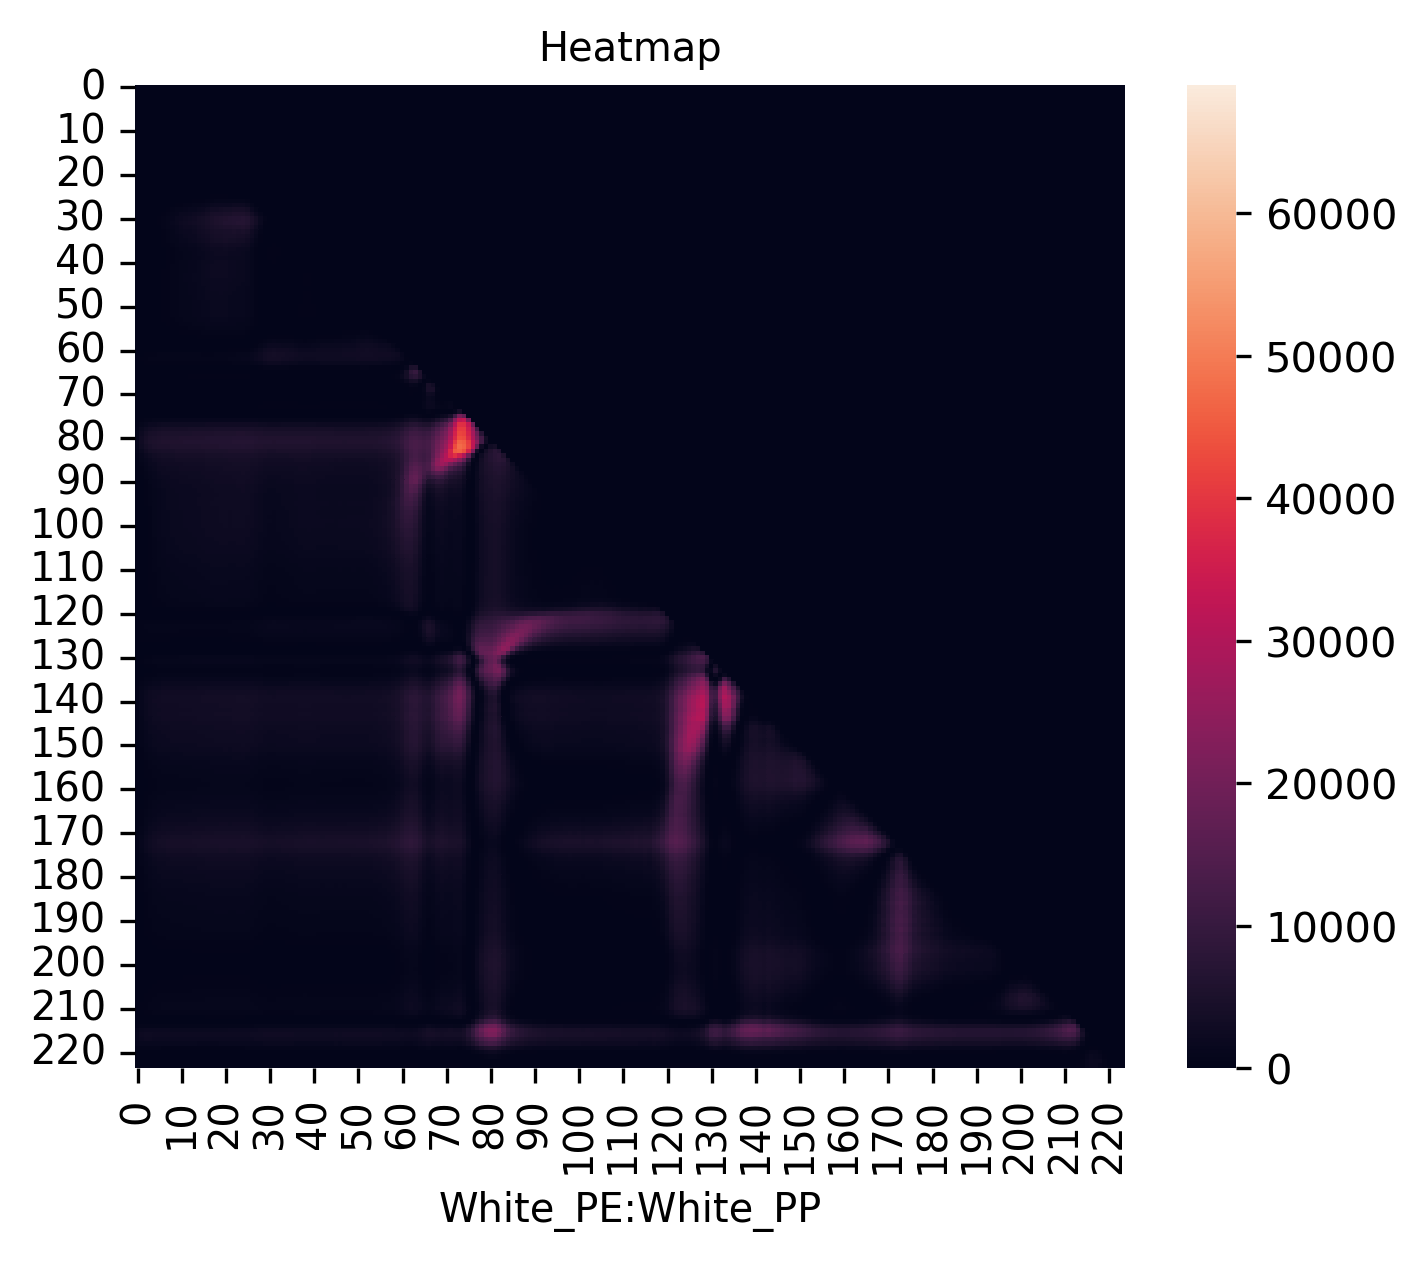

————————————————————————————————————————————————————————————————


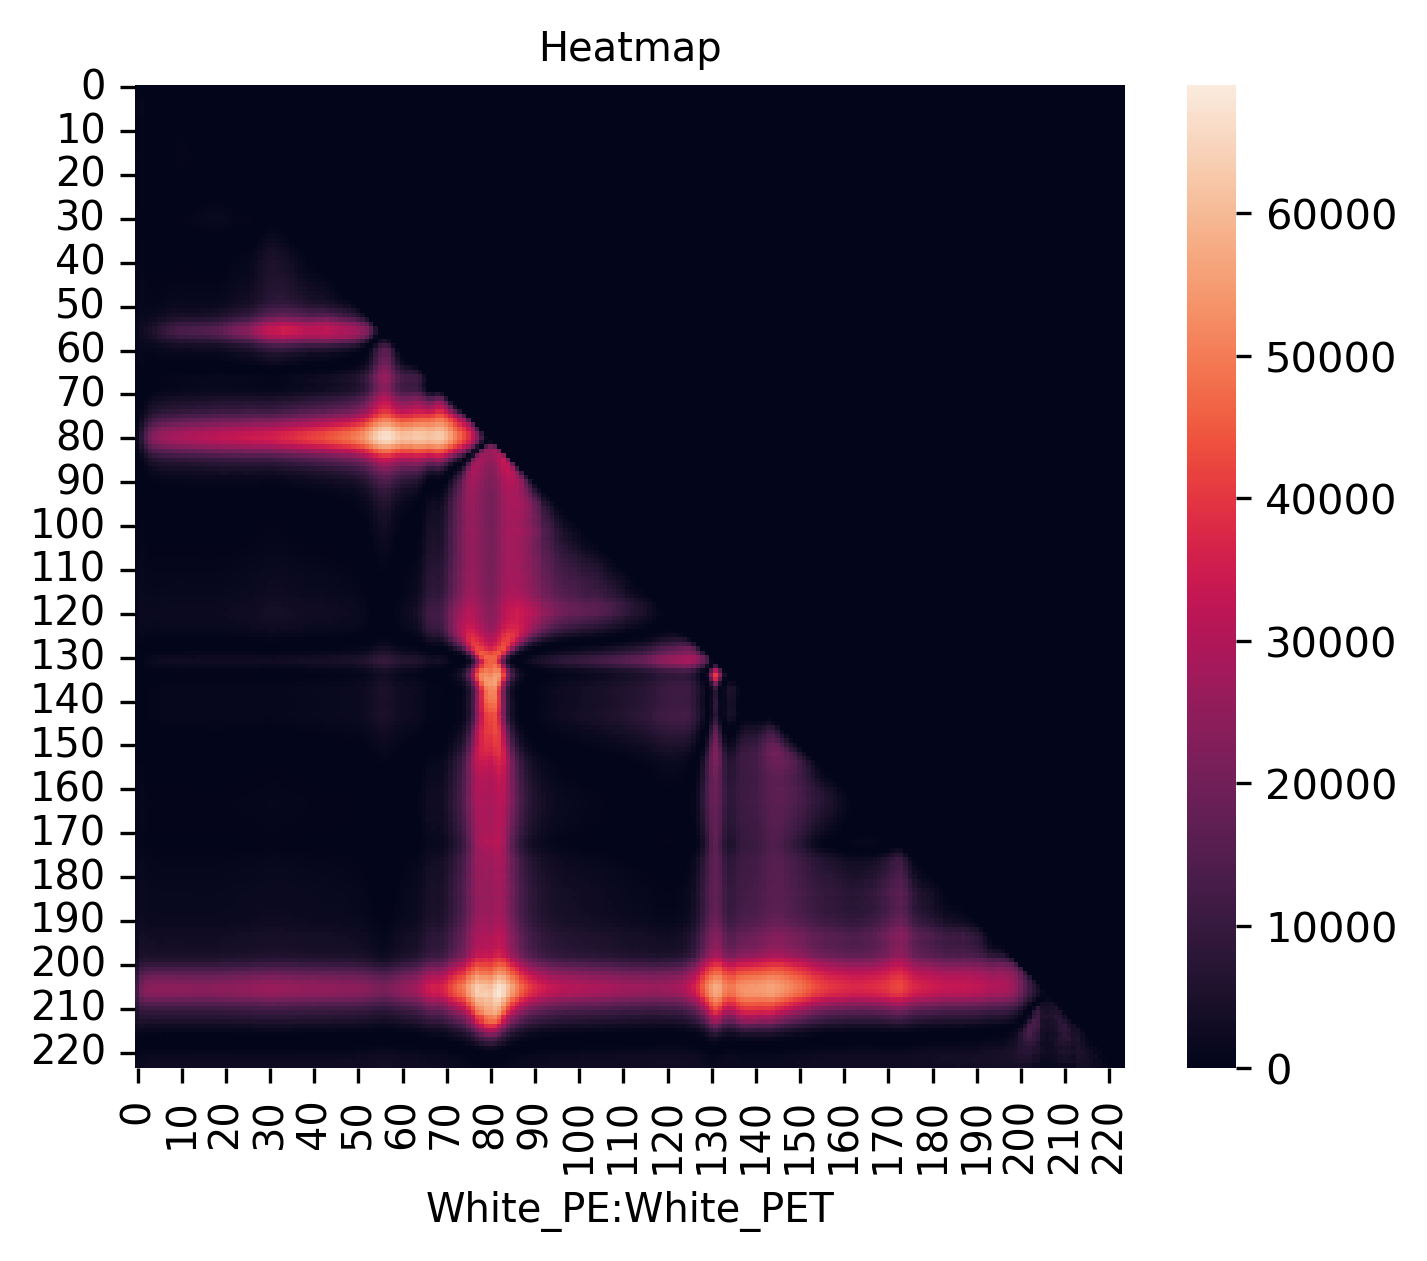

————————————————————————————————————————————————————————————————


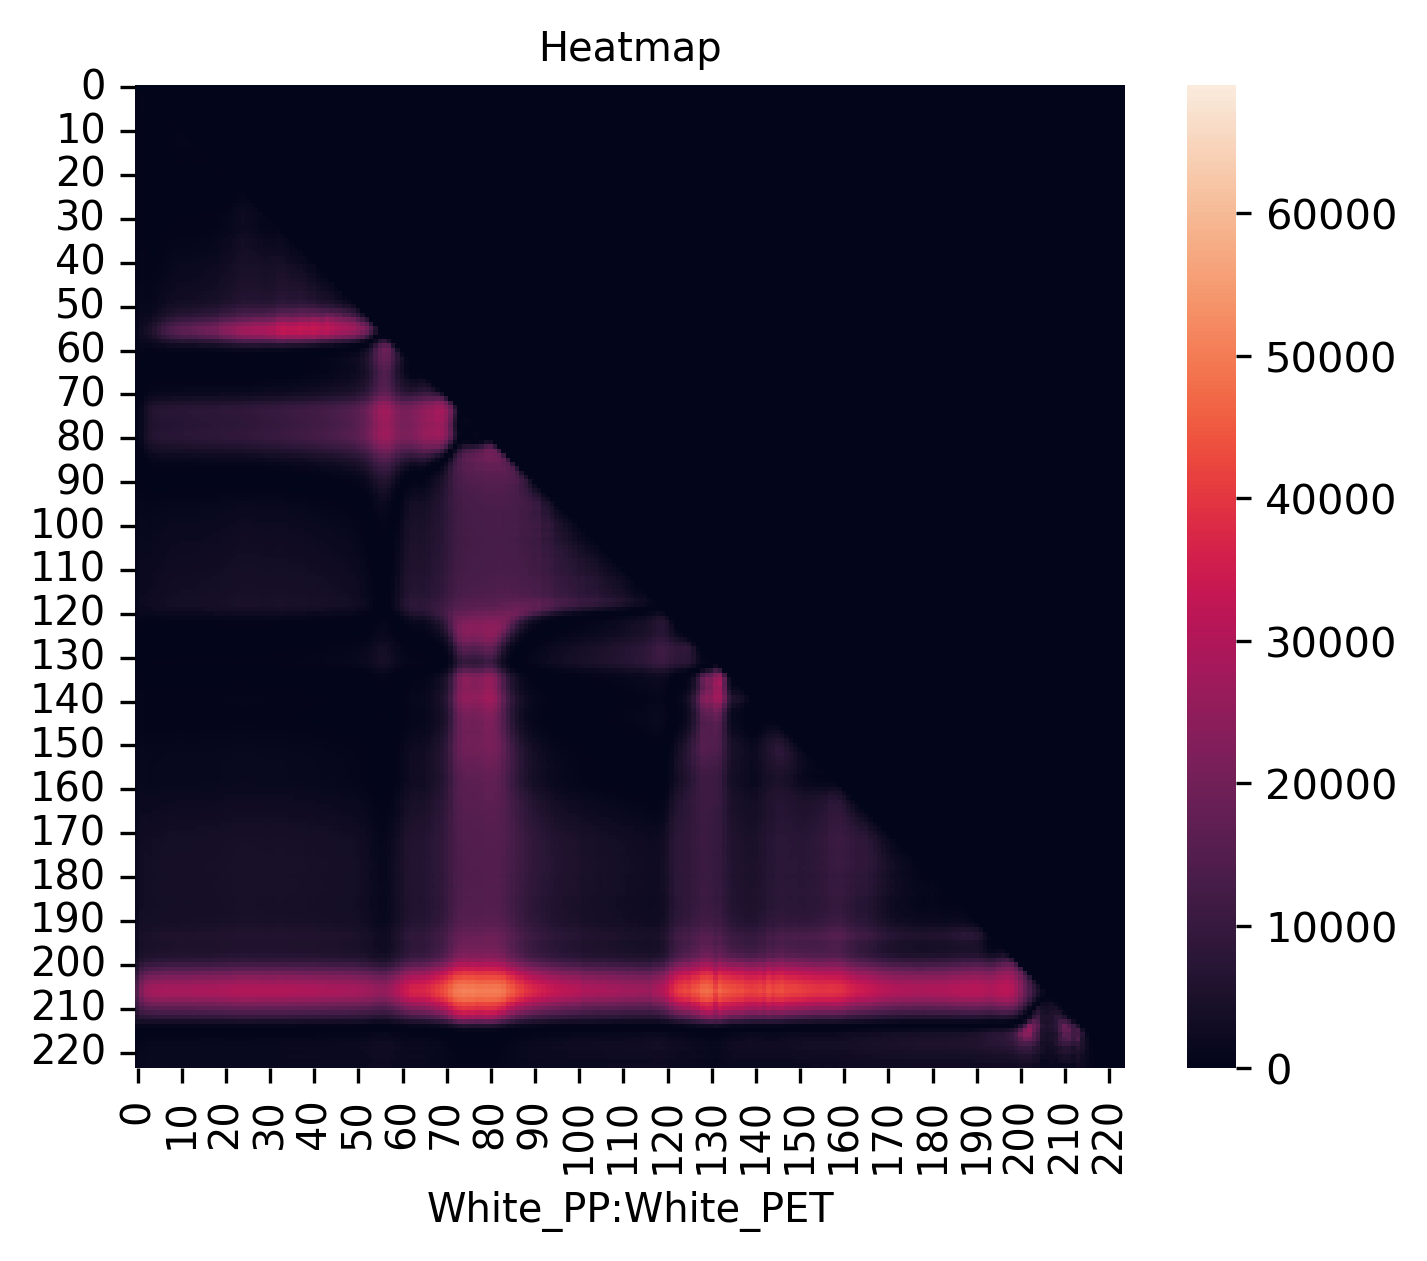

————————————————————————————————————————————————————————————————


In [7]:
# # 获取所有类的排列组合
# pairs = []  # 排列组合的列表, [(x1,y1), (x2,y2) ...]
# type_used = []
# for major_type_num in range(len(types_name)):
#     type_used.append(major_type_num)
#     for minor_type_num in range(len(types_name)):
#         if minor_type_num in type_used:
#             continue
#         pairs.append((major_type_num, minor_type_num))

# major_band_list = np.linspace(0, 4, 5, dtype=np.int)

major_band_list = np.linspace(0, 223, 224, dtype=np.int)
minor_band_list = major_band_list[0:]

pairs = [(1,2), (1,3), (2,3)]  # 排列组合的列表, [(x1,y1), (x2,y2) ...]

for pair in pairs:
    band_used = []
    F_value_matrix = np.zeros((len(major_band_list), len(minor_band_list)), dtype=np.float64)  # 存放F值的矩阵
    P_value_matrix = np.zeros((len(major_band_list), len(minor_band_list)), dtype=np.float64)  # 存放P值的矩阵
    
    for band_major in major_band_list:  # band_major: 被除数种类次序
        band_used.append(band_major)
        for band_minor in minor_band_list:  # band_minor: 除数种类次序
            if band_minor in band_used:
                continue
            # 把组合的名字拿出来, 方便看, 如type5和type6
            name_a = types_name[pair[0]]
            name_b = types_name[pair[1]]
            # 计算同一材料的不同波段比值, 方法1, 较慢
            # ratio_a = get_ratio(types_data[name_a], [band_major, band_minor], axis=0)
            # ratio_b = get_ratio(types_data[name_b], [band_major, band_minor], axis=0)
            # 方法2, 较快
            ratio_a = types_data[name_a][:, band_minor] / (types_data[name_a][:, band_major] + 1)  # +1 防止0除0
            ratio_b = types_data[name_b][:, band_minor] / (types_data[name_b][:, band_major] + 1)
    
            F_value, P_value = stats.f_oneway(ratio_a, ratio_b)
            F_value_matrix[band_major][band_minor] = F_value
            P_value_matrix[band_major][band_minor] = P_value
            # print("[%d, %d]:  F-value: %2f  P-value: %3f %% "
            #     % (band_major, band_minor, F_value, P_value * 100))

    # 绘制热力图并保存
    # F_value_matrix *= 255/F_value_matrix.max()  # 将结果变换为0-255的灰度值
    heatmap = plot_heatmap(F_value_matrix.T, fonts=1.2, dpi=300, v_max=69000,
                           xlabel=name_a + ":" + name_b)
    heatmap.savefig(R'D:\Keras-Tf-Mask_rcnn_Jiantao\ANOVA\Sensors_Journal_Data' + '\ANOVA_F_' +
                    types_name[pair[0]] + '_' + types_name[pair[1]] + '.png')  # 保存图片
    print("————————————————————————————————————————————————————————————————")
    """曾使用的灰度图绘制方法"""
    # # 绘制、保存F-value和P-value可视化图
    # from PIL import Image
    # # image_array 是归一化的二维浮点数矩阵
    # im = Image.fromarray(F_value_matrix.T)
    # im = im.convert('L')  # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
    # im.save(R'D:\Keras-Tf-Mask_rcnn_Jiantao\ANOVA\Sensors_Journal_Data' + '\ANOVA_F_' +
    #         types_name[pair[0]] + '_' + types_name[pair[1]] + '.png')
    # im.show()

    # P_value_matrix *= 255/P_value_matrix.max()  # 变换为0-255的灰度值
    # im_ = Image.fromarray(P_value_matrix.T)
    # im_ = im_.convert('L')  # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
    # im_.save(R'D:\Keras-Tf-Mask_rcnn_Jiantao\ANOVA\Sensors_Journal_Data' + '\ANOVA_P_' +
    #          types_name[pair[0]] + '_' + types_name[pair[1]] + '.png')
    # im_.show()

##### 三物体 计算

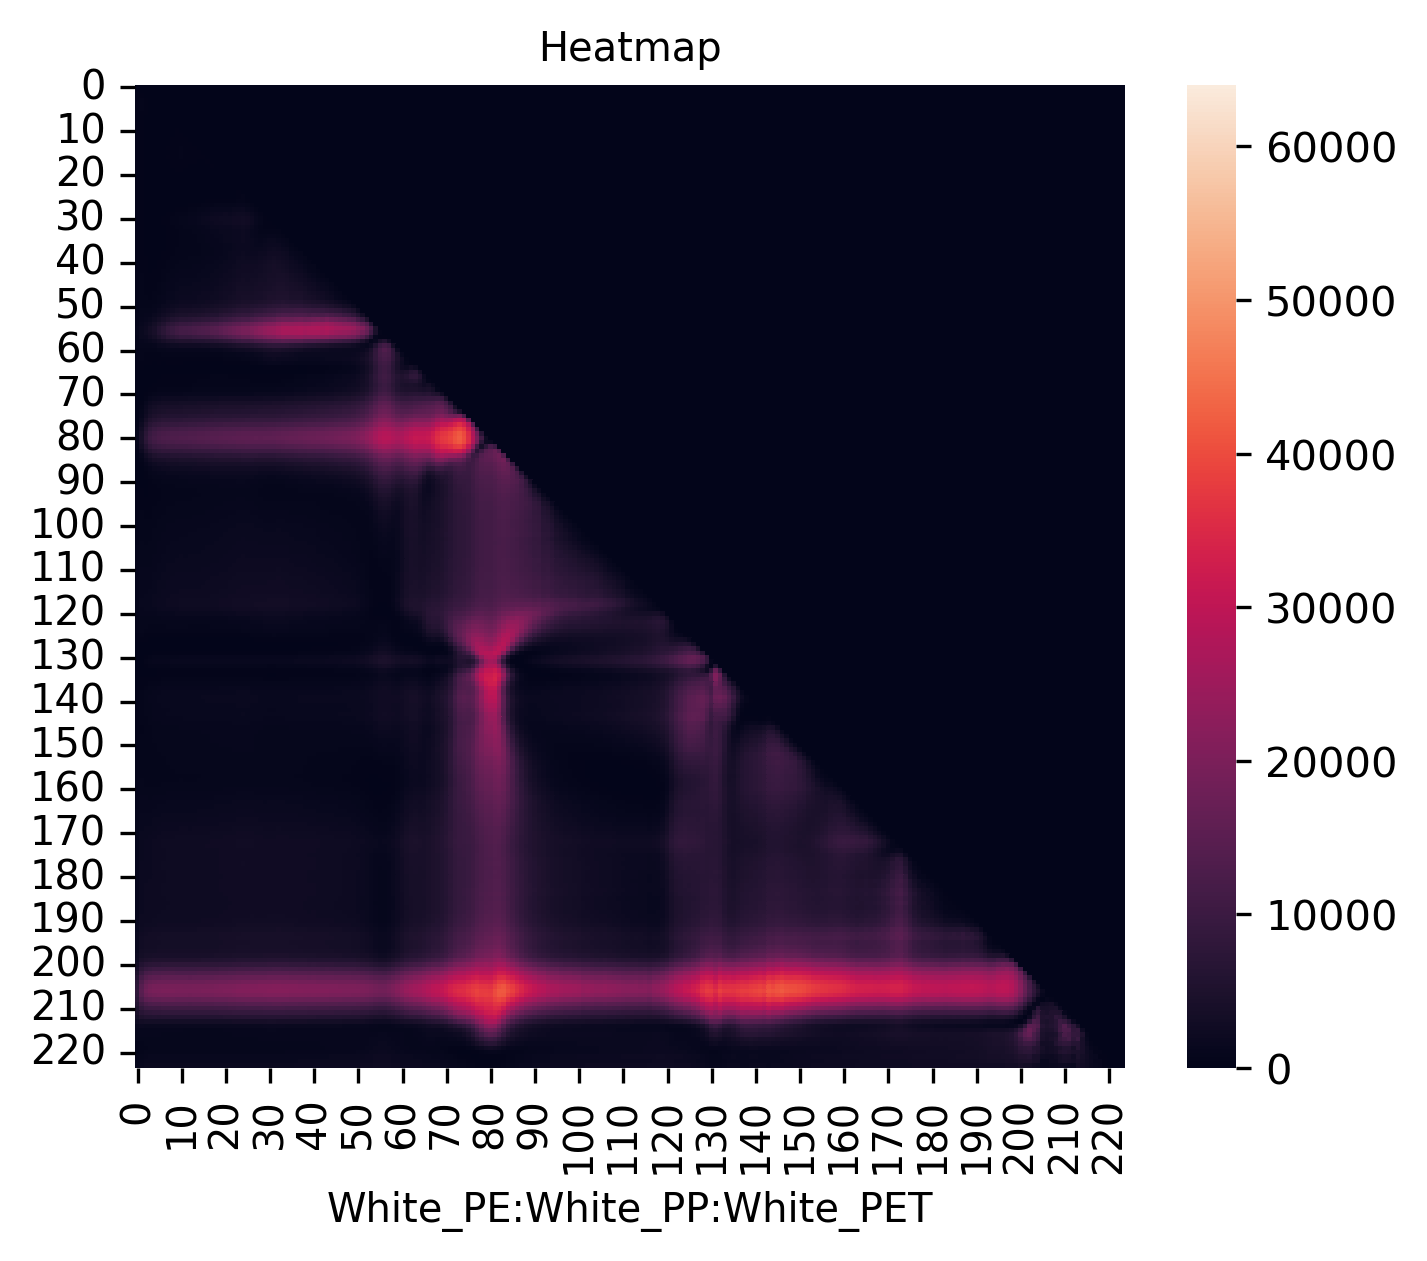

In [9]:
# # 获取所有类的排列组合
# pairs = []  # 排列组合的列表, [(x1,y1), (x2,y2) ...]
# type_used = []
# for major_type_num in range(len(types_name)):
#     type_used.append(major_type_num)
#     for minor_type_num in range(len(types_name)):
#         if minor_type_num in type_used:
#             continue
#         pairs.append((major_type_num, minor_type_num))

# major_band_list = np.linspace(0, 4, 5, dtype=np.int)

major_band_list = np.linspace(0, 223, 224, dtype=np.int)
minor_band_list = major_band_list[0:]

pairs = [(1,2,3)]  # 排列组合的列表, [(x1,y1,z1), (x2,y2,z2) ...]


for pair in pairs:
    band_used = []
    F_value_matrix = np.zeros((len(major_band_list), len(minor_band_list)), dtype=np.float64)  # 存放F值的矩阵
    P_value_matrix = np.zeros((len(major_band_list), len(minor_band_list)), dtype=np.float64)  # 存放P值的矩阵
    
    for band_major in major_band_list:  # band_major: 被除数种类次序
        band_used.append(band_major)
        for band_minor in minor_band_list:  # band_minor: 除数种类次序
            if band_minor in band_used:
                continue
            # 把组合的名字拿出来, 方便看, 如type5和type6
            name_a = types_name[pair[0]]
            name_b = types_name[pair[1]]
            name_c = types_name[pair[2]]
            # 计算同一材料的不同波段比值, 方法1, 较慢
            # ratio_a = get_ratio(types_data[name_a], [band_major, band_minor], axis=0)
            # ratio_b = get_ratio(types_data[name_b], [band_major, band_minor], axis=0)
            # 方法2, 较快
            ratio_a = types_data[name_a][:, band_minor] / (types_data[name_a][:, band_major] + 1)  # +1 防止0除0
            ratio_b = types_data[name_b][:, band_minor] / (types_data[name_b][:, band_major] + 1)
            ratio_c = types_data[name_c][:, band_minor] / (types_data[name_c][:, band_major] + 1)
    
            F_value, P_value = stats.f_oneway(ratio_a, ratio_b, ratio_c)
            F_value_matrix[band_major][band_minor] = F_value
            P_value_matrix[band_major][band_minor] = P_value
            # print("[%d, %d]:  F-value: %2f  P-value: %3f %% "
            #     % (band_major, band_minor, F_value, P_value * 100))

    # 绘制热力图并保存
    # F_value_matrix *= 255/F_value_matrix.max()  # 将结果变换为0-255的灰度值
    heatmap = plot_heatmap(F_value_matrix.T, fonts=1.2, dpi=300, v_max=64000,
                           xlabel=name_a + ":" + name_b + ":" + name_c)
    heatmap.savefig(R'D:\Keras-Tf-Mask_rcnn_Jiantao\ANOVA\Sensors_Journal_Data' + '\ANOVA_F_' +
                    types_name[pair[0]] + '_' + types_name[pair[1]] + '_' + types_name[pair[2]]
                    + '.png')  # 保存图片

### 验证计算方法正确性的代码

In [ ]:
name_a = types_name[pair[0]]
name_b = types_name[pair[1]]
# print(name_a, name_b)
ratio_a = get_ratio(types_data[name_a], [130, 206], axis=0)
ratio_b = get_ratio(types_data[name_b], [130, 206], axis=0)
# print(ratio_a)
# print('\n')
# print(ratio_b)
print(stats.f_oneway(ratio_a, ratio_b))

print(types_data[name_a].shape)

ratio_a = types_data[name_a][:,130] / types_data[name_a][:,206]
ratio_b = types_data[name_b][:,130] / types_data[name_b][:,206]
ratio_a = np.sort(ratio_a)
ratio_b = np.sort(ratio_b)

print(stats.f_oneway(ratio_a, ratio_b))
print(ratio_a.shape)
print(ratio_b.shape)
print(ratio_a)
print('\n')
print(ratio_b)

# print(types_data[name_a])